In [1]:
%matplotlib inline
import composeml as cp
import featuretools as ft
import pandas as pd
import data

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [2]:
df = data.load('data/train_FD004.txt')
df[df.columns[:7]].head()

,engine_no,time_in_cycles,operational_setting_1,operational_setting_2,operational_setting_3,sensor_measurement_1,sensor_measurement_2
0,1,1,42.0049,0.8400,100.0,445.00,549.68
1,1,2,20.0020,0.7002,100.0,491.19,606.07
2,1,3,42.0038,0.8409,100.0,445.00,548.95
3,1,4,42.0000,0.8400,100.0,445.00,548.70
4,1,5,25.0063,0.6207,60.0,462.54,536.10


In [3]:
def remaining_useful_life(df):
    return len(df) - 1

In [4]:
lm = cp.LabelMaker(
    target_entity='engine_no',
    time_index='time',
    labeling_function=remaining_useful_life,
)

In [5]:
lt = lm.search(
    df.sort_values('time'),
    num_examples_per_instance=10,
    minimum_data=100,
    gap=1,
    verbose=True,
)

lt.head()

Elapsed: 00:01 | Remaining: 00:00 | Progress: 100%|██████████| engine_no: 2490/2490 


,engine_no,time,remaining_useful_life
id,,,
0,1,2000-01-01 16:40:00,220
1,1,2000-01-01 16:50:00,219
2,1,2000-01-01 17:00:00,218
3,1,2000-01-01 17:10:00,217
4,1,2000-01-01 17:20:00,216


In [6]:
lt.describe()

Settings
--------
gap                                              1
label_type                              continuous
labeling_function            remaining_useful_life
minimum_data                                   100
num_examples_per_instance                       10
target_entity                            engine_no
window_size                                  61249


Transforms
----------
No transforms applied



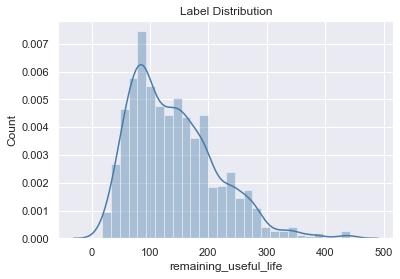

In [7]:
lt.plot.distribution();

In [8]:
lt = lt.bin(4, quantiles=True)

In [9]:
lt.describe()

Label Distribution
------------------
(128.0, 187.0]     629
(17.999, 83.0]     625
(187.0, 442.0]     614
(83.0, 128.0]      622
Total:            2490


Settings
--------
gap                                              1
label_type                                discrete
labeling_function            remaining_useful_life
minimum_data                                   100
num_examples_per_instance                       10
target_entity                            engine_no
window_size                                  61249


Transforms
----------
1. bin
  - bins:            4
  - labels:       None
  - quantiles:    True
  - right:        True



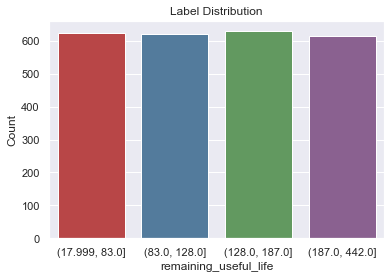

In [10]:
lt.plot.distribution();

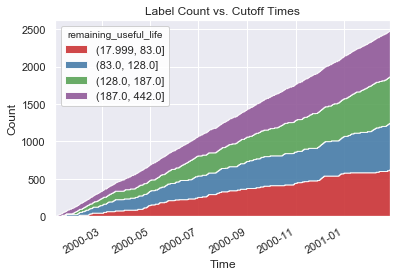

In [11]:
lt.plot.count_by_time();

In [12]:
es = ft.EntitySet('observations')

es.entity_from_dataframe(
    dataframe=df,
    entity_id='recordings',
    index='id',
    time_index='time',
    make_index=True,
)

es.normalize_entity(
    base_entity_id='recordings',
    new_entity_id='engines',
    index='engine_no',
)

es.normalize_entity(
    base_entity_id='recordings',
    new_entity_id='cycles',
    index='time_in_cycles',
)

Entityset: observations
  Entities:
    recordings [Rows: 61249, Columns: 28]
    engines [Rows: 249, Columns: 2]
    cycles [Rows: 543, Columns: 2]
  Relationships:
    recordings.engine_no -> engines.engine_no
    recordings.time_in_cycles -> cycles.time_in_cycles

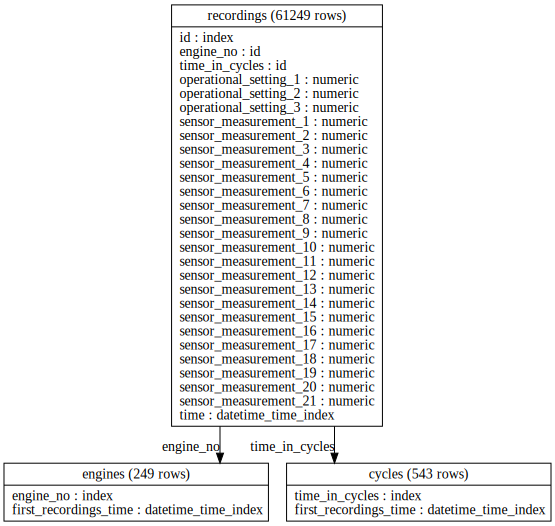

In [13]:
es.plot()

In [14]:
lt = lt.sample(frac=.2, random_state=0)

In [15]:
fm, fd = ft.dfs(
    entityset=es,
    target_entity='engines',
    agg_primitives=['last', 'max', 'min'],
    trans_primitives=[],
    cutoff_time=lt,
    cutoff_time_in_index=True,
    max_depth=3,
    verbose=True,
)

fm.head()

Built 292 features
Elapsed: 03:05 | Progress: 100%|██████████


,,LAST(recordings.sensor_measurement_2),LAST(recordings.sensor_measurement_21),LAST(recordings.sensor_measurement_1),LAST(recordings.sensor_measurement_4),LAST(recordings.sensor_measurement_5),LAST(recordings.sensor_measurement_11),LAST(recordings.sensor_measurement_7),LAST(recordings.sensor_measurement_9),LAST(recordings.sensor_measurement_19),LAST(recordings.sensor_measurement_18),...,MIN(recordings.cycles.LAST(recordings.sensor_measurement_11)),MIN(recordings.cycles.LAST(recordings.sensor_measurement_3)),MIN(recordings.cycles.MIN(recordings.sensor_measurement_16)),MIN(recordings.cycles.MAX(recordings.operational_setting_1)),MIN(recordings.cycles.LAST(recordings.sensor_measurement_18)),MIN(recordings.cycles.MIN(recordings.sensor_measurement_17)),MIN(recordings.cycles.MAX(recordings.operational_setting_3)),MIN(recordings.cycles.MIN(recordings.sensor_measurement_10)),MIN(recordings.cycles.MAX(recordings.sensor_measurement_18)),remaining_useful_life
engine_no,time,,,,,,,,,,,,,,,,,,,,,
233,2001-02-02 07:30:00,643.08,23.3473,518.67,1399.84,14.62,47.49,554.09,9068.13,100.00,2388,...,36.49,1250.55,0.02,42.0070,1915,302,100.0,0.93,2388,"(128.0, 187.0]"
146,2000-09-04 07:50:00,554.79,8.8768,449.44,1118.14,5.48,41.61,195.73,8346.50,100.00,2223,...,36.45,1254.83,0.02,42.0067,1915,302,100.0,0.93,2388,"(187.0, 442.0]"
105,2000-06-26 11:10:00,549.28,6.3080,445.00,1127.19,3.91,42.03,139.18,8332.78,100.00,2212,...,36.36,1251.50,0.02,42.0067,1915,302,100.0,0.93,2388,"(17.999, 83.0]"
240,2001-02-13 23:20:00,642.73,23.2631,518.67,1411.59,14.62,47.50,552.91,9048.65,100.00,2388,...,36.39,1251.07,0.02,42.0070,1915,302,100.0,0.93,2388,"(17.999, 83.0]"
229,2001-01-26 09:00:00,536.44,8.5711,462.54,1047.57,7.05,36.54,174.64,8008.89,84.93,1915,...,36.43,1249.84,0.02,42.0070,1915,302,100.0,0.93,2388,"(128.0, 187.0]"


In [16]:
y = fm.pop('remaining_useful_life')
y = y.astype('str')

x = fm.fillna(0)
x, fe = ft.encode_features(x, fd)

In [17]:
x_train, x_test, y_train, y_test = train_test_split(
    x,
    y,
    train_size=.8,
    test_size=.2,
    random_state=0,
)

In [18]:
clf = RandomForestClassifier(n_estimators=10, random_state=0)
clf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [19]:
y_hat = clf.predict(x_test)
print(classification_report(y_test, y_hat))

                precision    recall  f1-score   support

(128.0, 187.0]       0.65      0.79      0.71        28
(17.999, 83.0]       0.64      0.73      0.68        22
(187.0, 442.0]       0.81      0.84      0.82        25
 (83.0, 128.0]       0.67      0.40      0.50        25

      accuracy                           0.69       100
     macro avg       0.69      0.69      0.68       100
  weighted avg       0.69      0.69      0.68       100



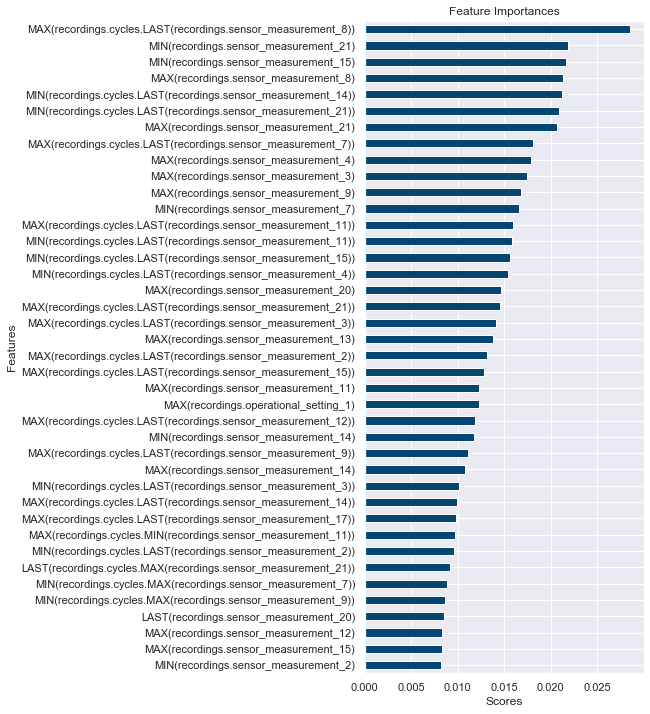

In [20]:
feature_importances = zip(x_train.columns, clf.feature_importances_)
feature_importances = pd.Series(dict(feature_importances))
feature_importances = feature_importances.rename_axis('Features')
feature_importances = feature_importances.sort_values()

top_features = feature_importances.tail(40)
plot = top_features.plot(kind='barh', figsize=(5, 12), color='#054571')
plot.set_title('Feature Importances')
plot.set_xlabel('Scores');